# Estimating Equilibrium Climate Sensitivity (ECS) in CMIP6 models

*Definition:* Equilibrium Climate Sensitivity is defined as change in global-mean near-surface air temperature (GMST) change due to an instantaneous doubling of CO$_{2}$ concentrations and once the coupled ocean-atmosphere-sea ice system has acheived a statistical equilibrium (i.e. at the top-of-atmosphere, incoming solar shortwave radiation is balanced by reflected solar shortwave and outgoing thermal longwave radiation).

This notebook uses the ["Gregory method"](https://agupubs.onlinelibrary.wiley.com/doi/epdf/10.1029/2003GL018747) to approximate the ECS of CMIP6 models based on the first 150 years after an abrupt quadrupling of CO$_{2}$ concentrations. The "Gregory Method" extrapolates the quasi-linear relationship between GMST and radiative imbalance at the top-of-atmosphere to estimate how much warming would occur if the system were in radiative balance at the top-of-atmosphere, which is by definition the equilibrium response. In particular, we extrapolate the linear relationship that occurs between 100 and 150 years after the abrupt quadrupling. Since the radiative forcing due to CO$_{2}$ is a logarithmic function of the CO$_{2}$ concentration, the GMST change from a first doubling is roughly the same as for a second doubling (to first order, we can assume feedbacks as constant), which means that the GMST change due to a quadrupling of CO$_{2}$ is roughly $\Delta T_{4 \times \text{CO}_{2}} = 2 \times \text{ECS}$. See also [Mauritsen et al. 2019](https://agupubs.onlinelibrary.wiley.com/doi/epdf/10.1029/2018MS001400) for a detailed application of the Gregory Method (with modifications) for the case of one specific CMIP6 model, the MPI-M Earth System Model.

For another take on applying the Gregory method to estimate ECS, see [Angeline Pendergrass' code](https://github.com/apendergrass/cmip6-ecs).

In [1]:
# extrapolate linear relationship between GMST and radiative imbalance
# between gregory_limits[0] and gregory_limits[1]
gregory_limits = [0,150] 

### Python packages

In [2]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import xesmf as xe
import cartopy
from tqdm.autonotebook import tqdm  # Fancy progress bars for our loops!
import intake
# util.py is in the local directory
# it contains code that is common across project notebooks
# or routines that are too extensive and might otherwise clutter
# the notebook design
import util

%matplotlib inline
plt.rcParams['figure.figsize'] = 12, 6
%config InlineBackend.figure_format = 'retina' 

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import sys


## Data catalogs

This notebook uses [`intake-esm`](https://intake-esm.readthedocs.io/en/latest/) to ingest and organize climate model output from the fresh-off-the-supercomputers Phase 6 of the Coupled Model Intercomparison Project (CMIP6). 

The file `https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv` in google cloud storage contains thousands of lines of metadata, each describing an individual climate model experiment's simulated data.

For example, the first line in the csv file contains the precipitation rate (`variable_id = 'pr'`), as a function of latitude, longitude, and time, in an individual climate model experiment with the BCC-ESM1 model (`source_id = 'BCC-ESM1'`) developed by the Beijing Climate Center (`institution_id = 'BCC'`). The model is *forced* by the forcing experiment SSP370 (`experiment_id = 'ssp370'`), which stands for the Shared Socio-Economic Pathway 3 that results in a change in radiative forcing of $\Delta F = 7.0$ W/m$^{2}$ from pre-industrial to 2100. This simulation was run as part of the `AerChemMIP` activity, which is a spin-off of the CMIP activity that focuses specifically on how aerosol chemistry affects climate.

In [3]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
df.head()

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year
0,AerChemMIP,BCC,BCC-ESM1,piClim-CH4,r1i1p1f1,Amon,ch4,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/piClim-CH4/...,NaN
1,AerChemMIP,BCC,BCC-ESM1,piClim-CH4,r1i1p1f1,Amon,clt,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/piClim-CH4/...,NaN
2,AerChemMIP,BCC,BCC-ESM1,piClim-CH4,r1i1p1f1,Amon,co2,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/piClim-CH4/...,NaN
3,AerChemMIP,BCC,BCC-ESM1,piClim-CH4,r1i1p1f1,Amon,evspsbl,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/piClim-CH4/...,NaN
4,AerChemMIP,BCC,BCC-ESM1,piClim-CH4,r1i1p1f1,Amon,hfls,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/piClim-CH4/...,NaN


The file `pangeo-cmip6.json` describes the structure of the CMIP6 metadata and is formatted so as to be read in by the `intake.open_esm_datastore` method, which categorizes all of the data pointers into a tiered collection. For example, this collection contains the simulated data from 28691 individual experiments, representing 48 different models from 23 different scientific institutions. There are 190 different climate variables (e.g. sea surface temperature, sea ice concentration, atmospheric winds, dissolved organic carbon in the ocean, etc.) available for 29 different forcing experiments.

In [4]:
col = intake.open_esm_datastore("../catalogs/pangeo-cmip6.json")
col

pangeo-cmip6-ESM Collection with 76150 entries:
	> 14 activity_id(s)

	> 24 institution_id(s)

	> 52 source_id(s)

	> 99 experiment_id(s)

	> 123 member_id(s)

	> 28 table_id(s)

	> 243 variable_id(s)

	> 8 grid_label(s)

	> 76150 zstore(s)

	> 60 dcpp_init_year(s)

Here, we show the various forcing experiments that climate modellers ran in these simulations. A few examples are:
 - `piControl` which fixes CO2 levels at pre-industrial concentrations of 300 ppm
 - `historical` which includes the historical evolution of greenhouse concentrations as well as historical volcanic eruptions, changes in solar luminosity, and changes in atmospheric aerosol concentrations (and some other, less impactful forcings).
 - `abrupt-4xCO2` in which the CO2 concentrations in an pre-industrial control simulation are abrupted quadrupled from 300 ppm to 1200 ppm.
 - `ssp585`, a `worst-case scenario` in which fossil-fueled development leads to a disastrous increase of $\Delta F = 8.5$ W/m$^{2}$ in radiative forcing.

In [19]:
df['experiment_id'].unique()

array(['piClim-CH4', 'piClim-NTCF', 'piClim-control', 'ssp370',
       'piClim-2xDMS', 'piClim-2xdust', 'piClim-2xfire', 'piClim-2xss',
       'piClim-BC', 'piClim-HC', 'piClim-N2O', 'piClim-OC', 'piClim-SO2',
       '1pctCO2-bgc', 'esm-ssp585', 'hist-bgc', 'amip-4xCO2',
       'amip-future4K', 'amip-m4K', 'amip-p4K', 'amip', 'abrupt-2xCO2',
       'abrupt-solp4p', 'abrupt-0p5xCO2', 'amip-lwoff', 'amip-p4K-lwoff',
       'abrupt-solm4p', 'aqua-4xCO2', 'aqua-control-lwoff',
       'aqua-control', 'aqua-p4K-lwoff', 'aqua-p4K', '1pctCO2',
       'abrupt-4xCO2', 'historical', 'piControl', 'esm-hist',
       'esm-piControl', 'ssp126', 'ssp245', 'ssp585',
       'esm-piControl-spinup', 'piControl-spinup', 'hist-GHG', 'hist-aer',
       'hist-nat', 'hist-CO2', 'hist-sol', 'hist-stratO3', 'hist-volc',
       'ssp245-GHG', 'ssp245-aer', 'ssp245-nat', 'ssp245-stratO3',
       'faf-heat', 'faf-passiveheat', 'faf-stress', 'faf-water',
       'faf-all', 'highresSST-present', 'hist-1950', 'control-1

# Analysis of Climate Model Output Data

### Loading data

`intake-esm` enables loading data directly into an [xarray.DataArray](http://xarray.pydata.org/en/stable/api.html#dataset), a metadata-aware extension of numpy arrays. `xarray` objects leverage [dask](https://dask.org/) to only read data into memory as needed for any specific operation (i.e. lazy evaluation). Think of `xarray` Datasets as ways of conveniently organizing large arrays of floating point numbers (e.g. climate model data) on an n-dimensional discrete grid, with important metadata such as units, variable, names, etc.

Note that data on the cloud are in [zarr](https://zarr.readthedocs.io/en/stable/) format, an extension of the metadata-aware format [netcdf](https://www.unidata.ucar.edu/software/netcdf/) commonly used in geosciences.

`intake-esm` has rules for aggegating datasets; these rules are defined in the collection-specification file.

#### Choice of simulated forcing experiments

Here, we choose the `piControl` experiment (in which CO2 concentrations are held fixed at a pre-industrial level of ~300 ppm) and `abrupt-4xCO2` experiment (in which CO2 concentrations are instantaneously quadrupled - or doubled twice - from a pre-industrial controrl state). Since the radiative forcing of CO2 is roughly a logarithmic function of CO2 concentrations, the ECS is roughly independent of the initial CO2 concentration. Thus, if one doubling of CO2 results in $ECS$ of warming, then two doublings (or, a quadrupling) results in $2 \times ECS$ of warming.

Ideally, we would choose the `abrupt-2xCO2` forcing experiment, but this seems to be currently unavaiable in Google Cloud Storage.

In [22]:
cat_ts = col.search(experiment_id=['abrupt-4xCO2','piControl'],  # pick the `abrupt-4xCO2` and `piControl` forcing experiments
                 table_id='Amon',             # choose to look at atmospheric variables (A) saved at monthly resolution (mon)
                 variable_id='ts',           # choose to look at near-surface air temperature (tas) as our variable
                 member_id = 'r1i1p1f1')      # arbitrarily pick one realization for each model (i.e. just one set of initial conditions)

In [23]:
# convert data catalog into a dictionary of xarray datasets
dset_dict_ts = cat_ts.to_dataset_dict(zarr_kwargs={'consolidated': True, 'decode_times': False})

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 40 group(s)


In [75]:
#dset_dict = dict(dset_dict_tas, **dset_dict_rad)

ts_dict = {}
for name, ds_rad in tqdm(dset_dict_ts.items()):
    model_name = name.split(".")[2]
        
    ds_ts = dset_dict_ts[name]
    
    # rename spatial dimensions if necessary
    if ('longitude' in ds_rad.dims) and ('latitude' in ds_rad.dims):
        ds_ts = ds_ts.rename({'longitude':'lon', 'latitude': 'lat'}) # some models labelled dimensions differently...
        
    ds_ts = xr.decode_cf(ds_ts) # temporary hack, not sure why I need this but has to do with calendar-aware metadata on the time variable
    
    # drop redundant variables (like "height: 2m")
    for coord in ds_tas.coords:
        if coord not in ['lat','lon','time']:
            ds_ts = ds_ts.drop(coord)

    ## Calculate latitudinal-mean surface temperature (GMST)
    ts1d = ds_ts['ts'].mean(dim=['lon'])
    
    # Add near-surface air temperature to dictionary
    ts_dict[name] = ts1d

/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/coding/times.py:459: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/coding/times.py:459: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/srv/conda/envs/notebook/lib/python3.7/site-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/coding/tim

#### Split dictionary of all simulations into `piControl` and `abrupt-4xCO2` dictionaries

And get rid of any models that don't have both experiments available.

In [76]:
ctrl_dict = {} # dictionary that will hold spliced DataArrays
for name, ds in ds_dict.items(): # Loop through dictionary
    model_name = name.split(".")[2]
    if 'piControl' not in name: continue
    ctrl_dict[model_name] = ds
    
abrupt_dict = {} # dictionary that will hold spliced DataArrays
for name, ds in ds_dict.items(): # Loop through dictionary
    model_name = name.split(".")[2]
    if ('abrupt-4xCO2' not in name) or (model_name not in ctrl_dict.keys()): continue
    abrupt_dict[model_name] = ds

In [77]:
ctrl_ts_dict = {} # dictionary that will hold spliced DataArrays
for name, ts in ts_dict.items(): # Loop through dictionary
    model_name = name.split(".")[2]
    if 'piControl' not in name: continue # keep only SSP simulations
    ctrl_ts_dict[model_name] = ts
    
abrupt_ts_dict = {} # dictionary that will hold spliced DataArrays
for name, ts in ts_dict.items(): # Loop through dictionary
    model_name = name.split(".")[2]
    if ('abrupt-4xCO2' not in name) or (model_name not in ctrl_ts_dict.keys()): continue # keep only SSP simulations
    abrupt_ts_dict[model_name] = ts
    
ctrl_ts_dict = {} # dictionary that will hold spliced DataArrays
for name, ts in ts_dict.items(): # Loop through dictionary
    model_name = name.split(".")[2]
    if ('piControl' not in name) or (model_name not in abrupt_ts_dict.keys()): continue # keep only SSP simulations
    ctrl_ts_dict[model_name] = ts

#### Take difference of time average of ts over 100 years a hundred years after beginning of integration

In [78]:
diff_ts_dict = {} # 

for name in ctrl_ts_dict.keys():
    ctrl_ts = ctrl_ts_dict[name].groupby('time.year').mean('time').compute()
    abrupt_ts = abrupt_ts_dict[name].groupby('time.year').mean('time').compute()
    diff_ts = abrupt_ts - ctrl_ts
    diff_ts_dict[name] = diff_ts

In [89]:
a = diff_ts_dict.pop('E3SM-1-0')

KeyError: 'E3SM-1-0'

Text(0.5, 0, 'Latitude (degrees North)')

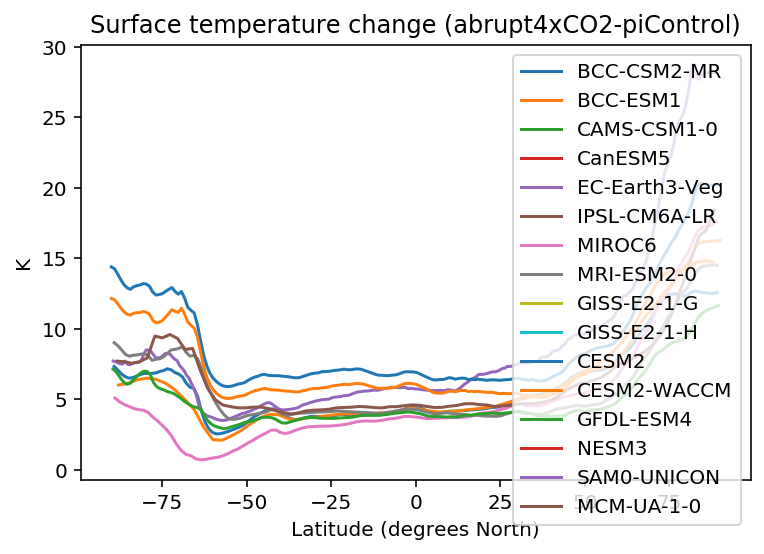

In [90]:
for name in diff_ts_dict.keys():
    diff_ts_dict[name].isel(year=slice(100,200)).mean('year').plot(label=name)
    
plt.legend()
plt.title('Surface temperature change (abrupt4xCO2-piControl)')
plt.ylabel('K')
plt.xlabel('Latitude (degrees North)')